### Harmonized Landsat and Sentinel 2 L2F
#### Direct NDVI computation


In [1]:
import os
from datetime import datetime
import pyproj
import odc.stac as odc_stac
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pystac_client import Client

from distributed import Client as dask_client
client = dask_client()

The "pystac_client" supports item search in the stac catalogue. We make use of eodc's stac catalogue https://stac.eodc.eu/api/v1 and look for the sen2like stac collection "sentinel2-landsat8-l2f".

Queries can include spatial and temporal filters:

In [2]:
def stac_search(collection, bbox, datetime, limit=10):
    client = Client.open('https://stac.eodc.eu/api/v1')
    results = client.search(collections=collection,
        max_items=limit,
        bbox = bbox,
        datetime=datetime
    )
    result_items = list(results.items())
    return result_items

In [3]:
bbox_E052N015 = [16.4, 47.7, 16.5, 47.8]
bbox_E053N015 = [17.4, 47.7, 17.5, 47.8]
bbox_E048N015 = [10.4, 46.8, 11.4, 47.3]

In [4]:
collection_name = "Harmonized Landsat and Sentinel 2 L2F"
collection = "sentinel2-landsat8-l2f"

result_items = stac_search(
    collection=collection, 
    bbox=bbox_E052N015, 
    datetime=["2024-06-05T00:00:00", "2024-06-06T00:00:00"])

print(result_items)

[<Item id=EU010M_E052N015T1_20240605T094549>]


For this specific query, one item was found: 

In [5]:
I = result_items[0]

With "odc_stac.load", we can directly load the assets of interest from the given stac item. We need to set the coordinate system as well as the resolution the data should be in. If we also set the chunks, as done below, the dask client will handle the large amount of data. As soon as we call ".values" or ".compute" or plot the data, the values will be loaded into memory. 

In [6]:
crs = pyproj.CRS.from_epsg(I.properties["proj:epsg"])

data = odc_stac.load(
    result_items, 
    crs=crs,
    bands=["B04", "B08"],
    resolution=10,
    chunks={"y":512, "x":512},
    )

display(data)
print("all NaN values in data: ", (np.isnan(data.B04)).all().values)

<xarray.Dataset> Size: 800MB
Dimensions:      (y: 10000, x: 10000, time: 1)
Coordinates:
  * y            (y) float64 80kB 1.6e+06 1.6e+06 1.6e+06 ... 1.5e+06 1.5e+06
  * x            (x) float64 80kB 5.2e+06 5.2e+06 5.2e+06 ... 5.3e+06 5.3e+06
    spatial_ref  int32 4B 27704
  * time         (time) datetime64[ns] 8B 2024-06-05T09:45:49
Data variables:
    B04          (time, y, x) float32 400MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B08          (time, y, x) float32 400MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

all NaN values in data:  False


We can compute the NDVI combining the red band "B04" and the nir band "B08" accordingly. 

In [ ]:
B04 = data.B04[0,2600:3000,6000:7000]
B08 = data.B08[0,2600:3000,6000:7000]
ndvi = (B08 - B04)/(B08 + B04)
display(ndvi)

<xarray.DataArray (y: 400, x: 1000)> Size: 2MB
dask.array<truediv, shape=(400, 1000), dtype=float32, chunksize=(400, 512), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 3kB 1.574e+06 1.574e+06 ... 1.57e+06 1.57e+06
  * x            (x) float64 8kB 5.26e+06 5.26e+06 ... 5.27e+06 5.27e+06
    spatial_ref  int32 4B 27704
    time         datetime64[ns] 8B 2024-06-05T09:45:49

To give an example, we load a subset of the data and we create a plot out of it:

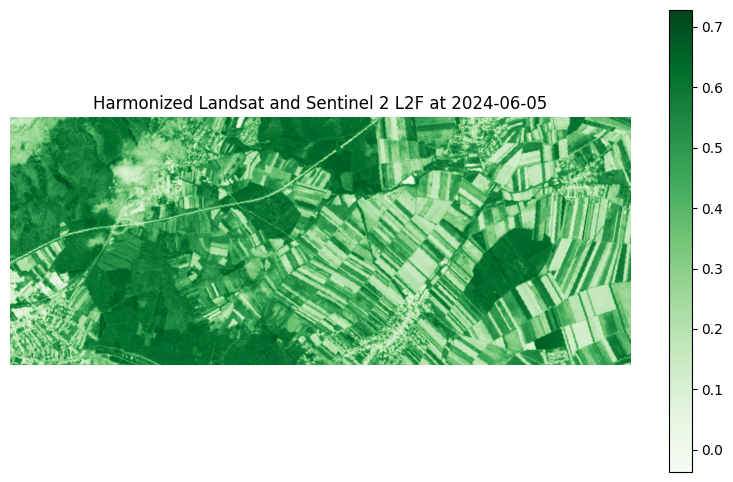

In [8]:
def plotting(x):
    time = x['time'].values.astype("datetime64[D]")
    plt.figure(figsize=(10,6))
    plt.title(f"{collection_name} at {time}")
    plt.imshow(x, cmap="Greens")
    plt.axis("off")
    plt.colorbar()
    plt.show()

plotting(ndvi)